In [6]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import  *
import numpy as np
import pandas as pd
from pprint import pprint
np.random.seed(2018)

import nltk
nltk.download('wordnet')

from gensim.models import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

# spacy for lemmatization
#import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn 
#import pyLDAvis.gensim
#import pyLDAvis.graphlab
#import pyLDAvis.graphlab as gl
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CHAITSU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# lemmatize the text to address thrird person words and convert verbs to simple present tense
def lemmatize_stemming(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text,pos='v')

# preprocess to break senetences into words, lower case words and remove puntuation
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [12]:
# Read multiple files from the directory and create the Tokens
import glob
import errno
path = 'C:/Users/CHAITSU/Git_Repo/EconTalk/*.txt'
files_list = glob.glob(path)
processed_docs = []
#print(files_list)
for file in files_list:
    try:
        with open(file,'r') as f:
            processed_docs.append(preprocess(f.read()))
            f.close()
    except Exception as e:
            print("Error {0}".format(str(e.args[0])).encode("utf-8"))
print(processed_docs[1][:20])

['russ', 'talk', 'minute', 'feedback', 'loop', 'problems', 'welfare', 'state', 'get', 'bigger', 'private', 'ways', 'help', 'get', 'smaller', 'charity', 'family', 'incentives', 'marry', 'smaller']


In [13]:
#processed_docs = list(map(preprocess,doc_sample))
dictionary = gensim.corpora.Dictionary(processed_docs)
#print(processed_docs[3])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 absolutely
1 accept
2 achieve
3 acknowledge
4 actually
5 additions
6 address
7 advocate
8 agenda
9 agree
10 alongside


In [15]:
# Frquency count of the words
dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=100000)
print(dictionary)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print(bow_corpus[1][:10])

Dictionary(29463 unique tokens: ['absolutely', 'accept', 'achieve', 'acknowledge', 'additions']...)
[(5, 1), (10, 10), (11, 15), (12, 3), (16, 6), (19, 8), (24, 4), (25, 1), (26, 2), (28, 1)]


In [9]:
# Display the Frequency of Word Counts from the Documnets
bow_doc_1 = bow_corpus[1]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], 
                                                     bow_doc_1[i][1]))
    if i > 10:
        break 

Word 5 ("address") appears 1 time.
Word 10 ("america") appears 10 time.
Word 11 ("american") appears 15 time.
Word 12 ("americans") appears 3 time.
Word 16 ("appeal") appears 6 time.
Word 19 ("approach") appears 8 time.
Word 24 ("articulate") appears 4 time.
Word 25 ("ask") appears 1 time.
Word 26 ("associations") appears 2 time.
Word 28 ("attitudes") appears 1 time.
Word 31 ("backward") appears 1 time.
Word 34 ("be") appears 1 time.


In [16]:
# Apply the TFIDF on the Corpus to add Weights
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
print(corpus_tfidf[0][:20])

[(0, 0.011138036522428679), (1, 0.0073929494950034898), (2, 0.035036335605631089), (3, 0.035406409501597132), (4, 0.035201604233899529), (5, 0.044845420349273718), (6, 0.012344724937143409), (7, 0.052025216640025268), (8, 0.023168516858227531), (9, 0.019631532983742699), (10, 0.089698780231477121), (11, 0.019214850601473415), (12, 0.040151661828693876), (13, 0.0097258309368538388), (14, 0.01725438526808467), (15, 0.030630228374548301), (16, 0.011176735053582338), (17, 0.013972792153664598), (18, 0.023074263900659964), (19, 0.014981893718923764)]


In [20]:
# using bag of words in LDA Model
lda_model1 = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2,iterations=50)
print("LDA Multicore using Bag of Words with 50 Iterations")
# Compute Perplexity
print('\nPerplexity: ', lda_model1.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model1, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print("----------------------------------------------------------------------------------------------------------------------")

lda_model2 = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2,iterations=1000)
print("LDA Multicore using Bag of Words with 1000 Iterations")
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print("----------------------------------------------------------------------------------------------------------------------")


LDA Multicore using Bag of Words with 50 Iterations

Perplexity:  -8.82252025645

Coherence Score:  0.28935264277
----------------------------------------------------------------------------------------------------------------------
LDA Multicore using Bag of Words with 1000 Iterations

Perplexity:  -8.69042170166

Coherence Score:  0.285320998119
----------------------------------------------------------------------------------------------------------------------


In [22]:
# Build the LDA Multiocore Model using the TFIDF with  50 Iterations 
lda_model_tfidf1 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20, id2word=dictionary, passes=2, workers=4,iterations=50)
#for idx, topic in lda_model_tfidf.print_topics(-1):
#    print('Topic: {} Word: {}'.format(idx, topic))
print("LDA Multicore using TFIDF with 50 Iterations")
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf1.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf1, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print("----------------------------------------------------------------------------------------------------------------------")

# Build the LDA Multiocore Model using the TFIDF with  1000 Iterations 
lda_model_tfidf2 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20, id2word=dictionary, passes=2, workers=4,iterations=1000)
print("LDA Multicore using TFIDF with 1000 Iterations")
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf2.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf2, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print("----------------------------------------------------------------------------------------------------------------------")



LDA Multicore using TFIDF with 50 Iterations

Perplexity:  -17.0504401459

Coherence Score:  0.382404178098
----------------------------------------------------------------------------------------------------------------------
LDA Multicore using TFIDF with 1000 Iterations

Perplexity:  -16.2631868571

Coherence Score:  0.40684507144
----------------------------------------------------------------------------------------------------------------------


In [58]:
lda_model_tfidf2.get_document_topics(bow_corpus[0])
#print(processed_docs[0])
lda_model_tfidf2.get_document_topics(bow_corpus[2])
#print(processed_docs[2])

[(5, 0.57029849), (9, 0.10026167), (16, 0.18147592), (18, 0.13114551)]

In [59]:
# Visualize the topics for the LDA Model with Number Topics as 20
pyLDAvis.enable_notebook()
#vis = pyLDAvis.sklearn.prepare(lda_model_tfidf2, bow_corpus, dictionary)
vis = pyLDAvis.gensim.prepare(lda_model_tfidf2, bow_corpus, dictionary)
from IPython.display import HTML
HTML(filename="C:/Users/CHAITSU/Documents/LDAvis.html")


In [1]:
#pyLDAvis.prepared_data_to_html(vis)
#print(type(dir(vis)))
#pprint(vis)

#pyLDAvis.show(vis,local=True)
#pyLDAvis.display(vis)

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME': r'C:/Users/CHAITSU/mallet-2.0.8/'})
mallet_path = 'C:/Users/CHAITSU/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=20, id2word=dictionary,iterations=50)

In [23]:
# Topic Distribution and Coherence using LDA Mallet Wrapper for a Random set of Topics
pprint(ldamallet.show_topics(formatted=False)[5])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

(4,
 [('health', 0.025285269709543569),
  ('doctor', 0.017686721991701244),
  ('women', 0.015612033195020747),
  ('insurance', 0.011203319502074689),
  ('medical', 0.0092064315352697098),
  ('heart', 0.008609958506224067),
  ('munger', 0.0085321576763485469),
  ('michael', 0.0078838174273858919),
  ('disease', 0.0078319502074688796),
  ('cancer', 0.0076763485477178419)])

Coherence Score:  0.50125087472


In [33]:
# Build a model to compute Coherence score for different set of Topics Using LDA Mallet Wrapper
def mallet_coherence_score(dictionary, corpus, texts, limit=40, start=2, step=6):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=num_topics, id2word=dictionary,
                                                 iterations=1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [34]:
model_list1, coherence_values1 = mallet_coherence_score(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)

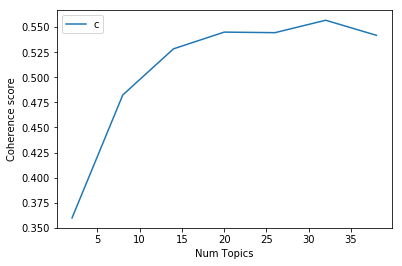

In [35]:
# Compare the Coherence score for different Topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3598
Num Topics = 8  has Coherence Value of 0.4824
Num Topics = 14  has Coherence Value of 0.5283
Num Topics = 20  has Coherence Value of 0.545
Num Topics = 26  has Coherence Value of 0.5444
Num Topics = 32  has Coherence Value of 0.5568
Num Topics = 38  has Coherence Value of 0.5418


In [37]:
# Select the model and print the topics
optimal_model1 = model_list1[3]
#model_topics = optimal_model1.show_topics(formatted=False)
pprint(optimal_model1.print_topics(num_words=10)[:5])

[(0,
  '0.032*"food" + 0.017*"water" + 0.013*"farm" + 0.011*"land" + '
  '0.009*"farmers" + 0.007*"fish" + 0.006*"corn" + 0.006*"plant" + '
  '0.006*"local" + 0.005*"crop"'),
 (1,
  '0.028*"data" + 0.027*"study" + 0.014*"evidence" + 0.011*"experiment" + '
  '0.011*"paper" + 0.011*"science" + 0.010*"research" + 0.008*"bias" + '
  '0.008*"analysis" + 0.008*"measure"'),
 (2,
  '0.064*"school" + 0.026*"education" + 0.022*"kid" + 0.020*"teach" + '
  '0.017*"students" + 0.016*"class" + 0.015*"college" + 0.014*"teachers" + '
  '0.012*"test" + 0.012*"parent"'),
 (3,
  '0.024*"hayek" + 0.015*"theory" + 0.012*"ideas" + 0.010*"keynes" + '
  '0.008*"friedman" + 0.007*"role" + 0.007*"knowledge" + 0.007*"debate" + '
  '0.006*"plan" + 0.006*"economist"'),
 (4,
  '0.019*"rule" + 0.013*"private" + 0.011*"regulation" + 0.010*"legal" + '
  '0.010*"license" + 0.006*"competition" + 0.006*"innovation" + 0.006*"patent" '
  '+ 0.005*"court" + 0.005*"provide"')]


In [38]:
# Convert LDA Mallet to LDA model to compute Coherence score for Visualizationa and comparision of Coherence Scores
def mallet2lda_coherence_scores(dictionary, corpus, texts, limit=40, start=2, step=6):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=num_topics, id2word=dictionary,
                                                 iterations=1000)
        lda_model = malletmodel2ldamodel(mallet_model)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [39]:
model_list2, coherence_values2 = mallet2lda_coherence_scores(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)

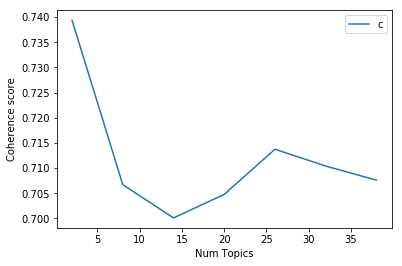

In [40]:
# Compare the Coherence score for different Topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7394
Num Topics = 8  has Coherence Value of 0.7067
Num Topics = 14  has Coherence Value of 0.7001
Num Topics = 20  has Coherence Value of 0.7048
Num Topics = 26  has Coherence Value of 0.7138
Num Topics = 32  has Coherence Value of 0.7104
Num Topics = 38  has Coherence Value of 0.7076


In [125]:
#dir(tm2)
#optimal_model = model_list2[3]
#vis2 = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, dictionary) 
#pyLDAvis.show(vis2)

In [43]:
# Select the model and print the topics
optimal_model2 = model_list2[3]
#model_topics = optimal_model2.show_topics(formatted=False)
pprint(optimal_model2.print_topics(num_words=10)[:5])

[(0,
  '0.000*"foment" + 0.000*"toothache" + 0.000*"overindulge" + '
  '0.000*"untethered" + 0.000*"subcategory" + 0.000*"equal" + 0.000*"husk" + '
  '0.000*"cellblock" + 0.000*"banners" + 0.000*"conventions"'),
 (1,
  '0.000*"embracement" + 0.000*"whammy" + 0.000*"motto" + 0.000*"nevadan" + '
  '0.000*"smellular" + 0.000*"wary" + 0.000*"toothpick" + 0.000*"redistribute" '
  '+ 0.000*"scratchy" + 0.000*"informants"'),
 (2,
  '0.000*"whomsoever" + 0.000*"microns" + 0.000*"abnormalities" + '
  '0.000*"burnham" + 0.000*"mortensen" + 0.000*"militant" + 0.000*"mccord" + '
  '0.000*"hotbot" + 0.000*"arcana" + 0.000*"yugoslavia"'),
 (3,
  '0.000*"fenway" + 0.000*"addendum" + 0.000*"rottenberg" + 0.000*"carole" + '
  '0.000*"reservations" + 0.000*"shaquille" + 0.000*"forgettable" + '
  '0.000*"admire" + 0.000*"darpa" + 0.000*"sleeves"'),
 (4,
  '0.000*"laborer" + 0.000*"toilets" + 0.000*"arbiter" + 0.000*"heroine" + '
  '0.000*"syrups" + 0.000*"reagan" + 0.000*"dcatch" + 0.000*"unchangeable" +

In [44]:
# Most Dominant Topic for each of the Documents
def format_topics_sentences(ldamodel,corpus,texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model1, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.3286,"smith, moral, society, social, adam, wealth, n...","[intro, record, date, june, russ, ambitious, b..."
1,1,18.0,0.3301,"smith, moral, society, social, adam, wealth, n...","[russ, talk, minute, feedback, loop, problems,..."
2,2,9.0,0.2596,"city, cities, project, private, cars, york, dr...","[intro, record, date, june, russ, topic, today..."
3,3,6.0,0.2680,"growth, labor, income, countries, workers, tra...","[russ, actually, make, clear, try, away, littl..."
4,4,10.0,0.4733,"technology, machine, information, knowledge, b...","[intro, record, date, june, russ, inevitable, ..."
5,5,10.0,0.5235,"technology, machine, information, knowledge, b...","[russ, okay, point, people, book, human, be, p..."
6,6,10.0,0.4614,"technology, machine, information, knowledge, b...","[intro, record, date, russ, practical, work, q..."
7,7,10.0,0.3359,"technology, machine, information, knowledge, b...","[russ, want, twitter, question, mention, book,..."
8,8,11.0,0.1993,"love, experience, watch, remember, attention, ...","[intro, record, date, russ, ambrose, bierce, b..."
9,9,11.0,0.2117,"love, experience, watch, remember, attention, ...","[russ, want, read, definition, read, definitio..."


In [45]:
# Most Representative Document for each topic #
# Group top 5 Documents under each Topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6315,"food, water, farm, land, farmers, fish, corn, ...","[intro, record, date, december, russ, begin, w..."
1,1.0,0.8580,"data, study, evidence, experiment, paper, scie...","[intro, record, date, december, russ, roberts,..."
2,2.0,0.6393,"school, education, kid, teach, students, class...","[intro, record, date, september, russ, book, h..."
3,3.0,0.6794,"hayek, theory, ideas, keynes, friedman, role, ...","[write, paper, call, socialist, calculation, d..."
4,4.0,0.6467,"rule, private, regulation, legal, license, com...","[russ, number, table, book, prison, gang, memb..."


In [46]:
#### Topic Distribution across Documents ####
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,18.0,"smith, moral, society, social, adam, wealth, n...",56.0,0.0538
1,18.0,"smith, moral, society, social, adam, wealth, n...",49.0,0.0471
2,9.0,"city, cities, project, private, cars, york, dr...",56.0,0.0538
3,6.0,"growth, labor, income, countries, workers, tra...",48.0,0.0462
4,10.0,"technology, machine, information, knowledge, b...",42.0,0.0404
5,10.0,"technology, machine, information, knowledge, b...",21.0,0.0202
6,10.0,"technology, machine, information, knowledge, b...",108.0,0.1038
7,10.0,"technology, machine, information, knowledge, b...",35.0,0.0337
8,11.0,"love, experience, watch, remember, attention, ...",42.0,0.0404
9,11.0,"love, experience, watch, remember, attention, ...",40.0,0.0385
